### 1) set up python libraries

In [1]:
import warnings, numpy as np, pandas as pd, yfinance as yf, matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import f as fdist
import matplotlib.pyplot as plt

### 2) Set up data fecthing

In [2]:
START = "2015-01-01"
END = "2025-10-23"
FREQ = "W-FRI"

EQUITY_TICKERS = {
    "US": "^GSPC",
    "EU": "^STOXX50E",
    "JP": "^N225",
}

YAHOO_3M = "^IRX"  # 1.00 ≈ 1 bp
YAHOO_10Y = "^TNX"  # 1.00 ≈ 10 bp

# Transition variable
VIX_TICKER = "^VIX"

# Shock x for the first pass: "US_10Y"
X_SOURCE = "US_10Y"


In [10]:
abc = yf.download("^TNX")
print(abc.tail())

deh = yf.download("^IRX")
print(deh.tail())

[*********************100%***********************]  1 of 1 completed


Price       Close   High    Low   Open Volume
Ticker       ^TNX   ^TNX   ^TNX   ^TNX   ^TNX
Date                                         
2025-11-03  4.106  4.122  4.097  4.106      0
2025-11-04  4.089  4.101  4.079  4.097      0
2025-11-05  4.157  4.161  4.093  4.097      0
2025-11-06  4.093  4.132  4.077  4.132      0
2025-11-07  4.093  4.112  4.066  4.087      0


[*********************100%***********************]  1 of 1 completed

Price       Close   High    Low   Open Volume
Ticker       ^IRX   ^IRX   ^IRX   ^IRX   ^IRX
Date                                         
2025-11-03  3.783  3.788  3.728  3.728      0
2025-11-04  3.793  3.800  3.788  3.797      0
2025-11-05  3.788  3.793  3.785  3.785      0
2025-11-06  3.763  3.775  3.757  3.772      0
2025-11-07  3.757  3.757  3.753  3.757      0


### 3) Data fecthing  using `yfinance`, resampling to last friday of each week, obtaining log returns for equitites and simples differences for US3M and US10Y

In [11]:
def _resample_last(df: pd.DataFrame, freq: str) -> pd.DataFrame:
    return df.resample(freq).last()

def fetch_equities_yahoo(ticker_map, start, end, freq):
    frames = []
    for unit, ticker in ticker_map.items():
        px = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=False)[["Close"]]
        px.columns = [unit]
        frames.append(px)
    wide = pd.concat(frames, axis=1).dropna(how="all")
    wide = _resample_last(wide, freq).dropna(how="any")
    return wide


def fetch_vix_yahoo(start, end, freq):
    vix = yf.download(VIX_TICKER, start=start, end=end, progress=False, auto_adjust=False)[["Close"]]
    vix.columns = ["VIX"]
    vix = _resample_last(vix, freq).dropna()
    return vix["VIX"]


def fetch_rates_yahoo(start, end, freq):
    irx = yf.download(YAHOO_3M, start=start, end=end, progress=False, auto_adjust=False)[["Close"]].rename(
        columns={"Close": "IRX"})
    tnx = yf.download(YAHOO_10Y, start=start, end=end, progress=False, auto_adjust=False)[["Close"]].rename(
        columns={"Close": "TNX"})
    rates = pd.concat([irx, tnx], axis=1)
    rates = _resample_last(rates, freq).dropna()
    out = pd.DataFrame(index=rates.index)
    out["US_3M_level_yahoo"] = rates["IRX"]
    out["US_10Y_level_yahoo"] = rates["TNX"]
    # changes in bps
    out["d_US_3M_bps"] = rates["IRX"].diff()  *100 # IRX to basis points
    out["d_US_10Y_bps"] = rates["TNX"].diff() * 100  # TNX to basis points
    return out.dropna()


def log_returns(levels_df: pd.DataFrame) -> pd.DataFrame:
    return np.log(levels_df).diff().dropna()

### 4) Convert from wide to long, build the pannel, align dates and pr

* Convert prices $P_{i,t}$ from **wide** to **long** (`to_long_panel`) so rows are ($t,i$), which is the natural format for fixed-effects and panel estimators.
* Build $y_{i,t}$=$\Delta$ $\ln P_{i,t}$ (log returns: stationary, interpretable), set the **shock** $x_t$ $\in$ {$\Delta$ $i^{10Y}_t$,$\Delta$ $i^{3M}_t$} in **bps** (innovation-like, comparable), and pick a **state** $q_t$ (e.g., 10Y level/VIX) for PSTR.
* **Align dates** to the common intersection of (y,x,q) to ensure a consistent sample across variables and units.
* **Broadcast** the time-common $x_t$,$q_t$ to all units (i), merge with $y_{i,t}$, and **standardize** for stable identification of $\gamma$,$c$ in PSTR.
* **Balance** the panel and return tidy columns `{date, unit, y, x, q, q_std}`; later use **clustered SEs by date** since shocks are common across units.


In [12]:
def to_long_panel(wide_df: pd.DataFrame, name: str) -> pd.DataFrame:
    out = wide_df.stack().rename(name).to_frame()
    out.index.set_names(["date", "unit"], inplace=True)
    return out.reset_index()


def build_panel(px_wide: pd.DataFrame, rates_df: pd.DataFrame, q_series: pd.Series, x_source="US_10Y"):
    r_wide = log_returns(px_wide)
    y_long = to_long_panel(r_wide, "y")


    if x_source == "US_10Y":
        x = rates_df["d_US_10Y_bps"].copy()
    elif x_source == "US_3M":
        x = rates_df["d_US_3M_bps"].copy()
    else:
        raise ValueError("x_source must be 'US_10Y' or 'US_3M'")
    x = x.rename("x").dropna()

    # transition q (Series)
    if isinstance(q_series, pd.DataFrame):
        q = q_series.iloc[:, 0]
    else:
        q = q_series
    q = q.rename("q").dropna()

    # Align dates
    common_idx = r_wide.index.intersection(x.index).intersection(q.index)
    r_wide = r_wide.loc[common_idx]
    x = x.loc[common_idx]
    q = q.loc[common_idx]

    # Broadcast x, q across units
    x_long = pd.DataFrame({"date": common_idx, "x": x.values})
    q_long = pd.DataFrame({"date": common_idx, "q": q.values})
    panel = to_long_panel(r_wide, "y").merge(x_long, on="date").merge(q_long, on="date")

    # Standardize q
    panel["q_std"] = (panel["q"] - panel["q"].mean()) / panel["q"].std(ddof=0)

    # Balance the panel
    counts = panel.groupby("unit")["date"].count()
    full_T = counts.max()
    keep_units = counts[counts == full_T].index
    panel_bal = panel[panel["unit"].isin(keep_units)].reset_index(drop=True)

    return panel_bal[["date", "unit", "y", "x", "q", "q_std"]]

### 5) Build the Weekly Panel to allow state dependent effects and Quick Checks and EDA


In [13]:
# 3) BUILD WEEKLY PANEL (Yahoo)
#---------------------------------------------------------------
px = fetch_equities_yahoo(EQUITY_TICKERS, START, END, FREQ)
rates = fetch_rates_yahoo(START, END, FREQ)
vix = fetch_vix_yahoo(START, END, FREQ)

# Choose q (you can switch below). Here: q = 10Y level (Yahoo units)
q_10y = rates["US_10Y_level_yahoo"]

# Build panel with x = Δ10Y (bps) initially
panel = build_panel(px_wide=px, rates_df=rates, q_series=q_10y, x_source=X_SOURCE)

# ---- Descriptives / EDA ----
print("Panel shape:", panel.shape)
print(panel.groupby("unit")["date"].count())
print(panel[["y", "x", "q"]].describe(percentiles=[.05, .25, .5, .75, .95]).T)


Panel shape: (1686, 6)
unit
EU    562
JP    562
US    562
Name: date, dtype: int64
    count      mean        std        min         5%       25%       50%  \
y  1686.0  0.001695   0.026095  -0.223003  -0.039609 -0.010658  0.003201   
x  1686.0  0.348043  11.680021 -42.100000 -18.199992 -6.800008 -0.099999   
q  1686.0  2.619980   1.128417   0.536000   0.749000  1.755000  2.393000   

        75%        95%        max  
y  0.015640   0.039711   0.158171  
x  7.300001  21.099997  50.800014  
q  3.695000   4.441000   4.924000  


### 6) Exploratory Data Analysis

px.head():
                      US           EU            JP
Date                                              
2015-01-09  2044.810059  3042.899902  17197.730469
2015-01-16  2019.420044  3202.239990  16864.160156
2015-01-23  2051.820068  3382.550049  17511.750000
2015-01-30  1994.989990  3351.439941  17674.390625
2015-02-06  2055.469971  3398.159912  17648.500000 

rets.head():
                   US        EU        JP
Date                                    
2015-01-16 -0.012495  0.051040 -0.019587
2015-01-23  0.015917  0.054779  0.037681
2015-01-30 -0.028088 -0.009240  0.009245
2015-02-06  0.029865  0.013844 -0.001466
2015-02-13  0.019998  0.014441  0.014896 

vix.head():
 Date
2015-01-02    17.790001
2015-01-09    17.549999
2015-01-16    20.950001
2015-01-23    16.660000
2015-01-30    20.969999
Freq: W-FRI, Name: VIX, dtype: float64 

rates.head():
             US_3M_level_yahoo  US_10Y_level_yahoo  d_US_3M_bps  d_US_10Y_bps
Date                                                   

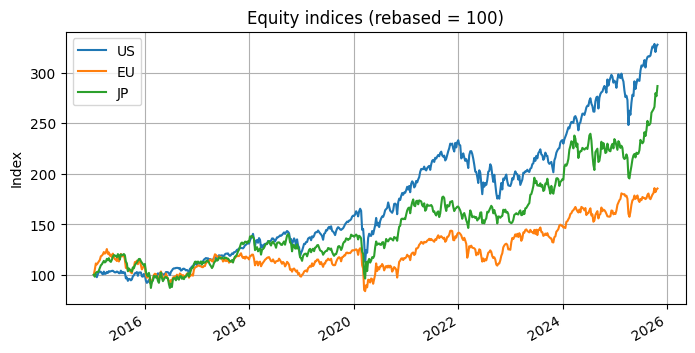

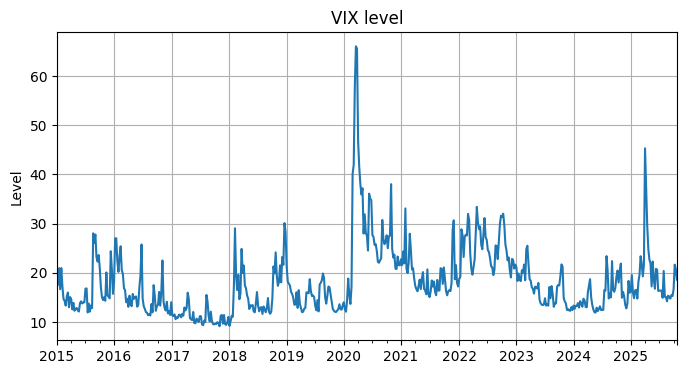

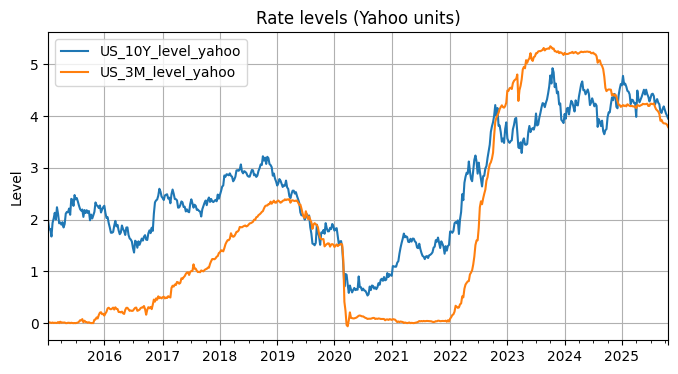

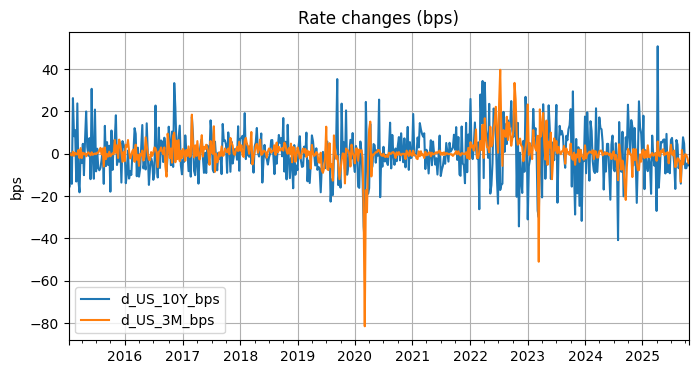

In [14]:
# 1) Quick heads
print("px.head():\n", px.head(), "\n")
print("rets.head():\n", np.log(px).diff().dropna().head(), "\n")  # rets if you didn't keep it
print("vix.head():\n", vix.head(), "\n")
print("rates.head():\n", rates.head(), "\n")

# 2) Describe (basic stats)
print("\n=== DESCRIBE: Equity levels (px) ===\n", px.describe())
print("\n=== DESCRIBE: Equity log-returns (rets) ===\n", np.log(px).diff().dropna().describe())
print("\n=== DESCRIBE: VIX ===\n", vix.describe())
print("\n=== DESCRIBE: Rates (levels + diffs) ===\n", rates.describe())

# 3) Correlation (returns vs rate diffs)
rets = np.log(px).diff().dropna()
corr_df = rets.join(rates[["d_US_10Y_bps","d_US_3M_bps"]], how="inner").corr()
print("\n=== CORRELATION MATRIX (rets & rate diffs) ===\n", corr_df)

# 4) Very simple plots: evolution over time
(px / px.iloc[0] * 100).plot(title="Equity indices (rebased = 100)")
plt.xlabel(""); plt.ylabel("Index"); plt.show()

vix.plot(title="VIX level")
plt.xlabel(""); plt.ylabel("Level"); plt.show()

rates[["US_10Y_level_yahoo","US_3M_level_yahoo"]].plot(title="Rate levels (Yahoo units)")
plt.xlabel(""); plt.ylabel("Level"); plt.show()

rates[["d_US_10Y_bps","d_US_3M_bps"]].plot(title="Rate changes (bps)")
plt.xlabel(""); plt.ylabel("bps"); plt.show()


### 7) Linearity Test with Unit Fixed Effects

* Test whether the slope on the rate shock varies smoothly with the state $q_t$ (PSTR pretest).
* Demean by unit, partial out the linear term $x_t$, and run an F-test on $x_t$ $\times$ $q_t$, $x_t$ $\times$ $q_t^2$, $x_t$ $\times$ $q_t^3$ ; reject ⇒ nonlinearity.


In [15]:
def unit_demean(s: pd.Series, unit: pd.Series) -> np.ndarray:
    df = pd.DataFrame({"s": s.values, "unit": unit.values})
    si = df.groupby("unit")["s"].transform("mean")
    return (df["s"] - si).values


def linearity_test_unitFE_partial(panel: pd.DataFrame):
    df = panel.copy()
    z = (df["q"] - df["q"].mean()) / df["q"].std(ddof=0)  # standardized q

    # unit-demean
    y_dm = unit_demean(df["y"], df["unit"])
    x_dm = unit_demean(df["x"], df["unit"])
    xz_dm = unit_demean(df["x"] * z, df["unit"])
    xz2_dm = unit_demean(df["x"] * (z ** 2), df["unit"])
    xz3_dm = unit_demean(df["x"] * (z ** 3), df["unit"])

    # Restricted: y_dm ~ const + x_dm
    Xr = sm.add_constant(x_dm)
    rr = sm.OLS(y_dm, Xr).fit()

    # Partial-out x_dm from y and the 3 nonlinear regressors (Frisch–Waugh–Lovell)
    y_res = rr.resid
    Z = np.column_stack([xz_dm, xz2_dm, xz3_dm])
    Z_res = np.empty_like(Z)
    for j in range(Z.shape[1]):
        Z_res[:, j] = sm.OLS(Z[:, j], Xr).fit().resid

    # Auxiliary: y_res ~ const + Z_res
    Xu = sm.add_constant(Z_res)
    ur = sm.OLS(y_res, Xu).fit()
    RSS0 = np.sum(y_res ** 2)
    RSSu = ur.ssr
    df_num, df_den = 3, int(ur.df_resid)
    F = ((RSS0 - RSSu) / df_num) / (RSSu / df_den)
    pF = 1 - fdist.cdf(F, df_num, df_den)
    print(f"Linearity test (unit FE, partialed): F({df_num},{df_den})={F:.3f}, p={pF:.4f}")
    return {"F": F, "pval": pF, "ur": ur}


lin_test = linearity_test_unitFE_partial(panel)

Linearity test (unit FE, partialed): F(3,1682)=21.754, p=0.0000


### 8) PSTR(1) Estimation (Unit FE) + Marginal Effects

* Estimate a **Smooth Transition** model: $E$[$y_{it}$|$x_t$,$q_t$]=$\beta_0$ $x_t$+$\beta_1$ $x_t$,$G$($q_t^{*}$;$\gamma,c$), with unit demeaning, logistic (G), grid + local search for $\gamma,c$, then OLS with **date-clustered SEs**.
* Plot $G(q^{*})$and the **marginal effect** to see how the return–rate sensitivity changes across states.


PSTR(1) unit-FE results (cluster-by-date):
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.233e-19      0.001  -3.46e-16      1.000      -0.002       0.002
x1             0.0010      0.000      3.430      0.001       0.000       0.002
x2            -0.0026      0.001     -3.325      0.001      -0.004      -0.001


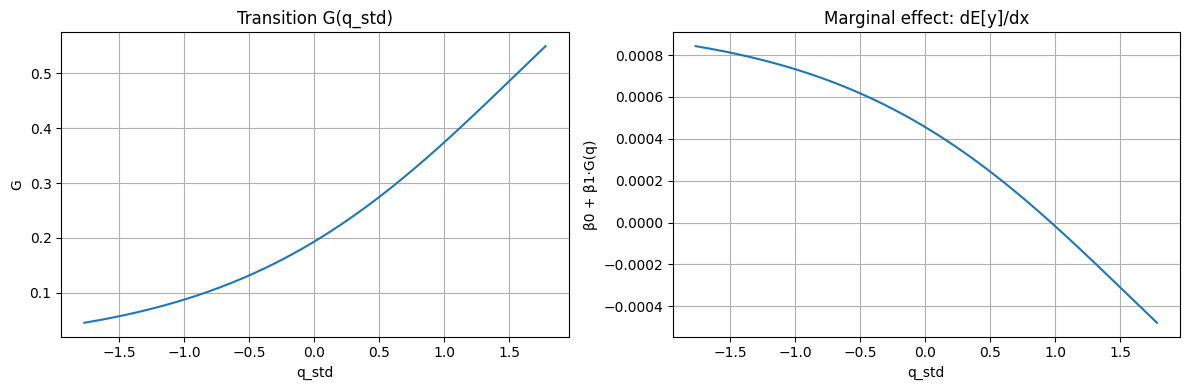

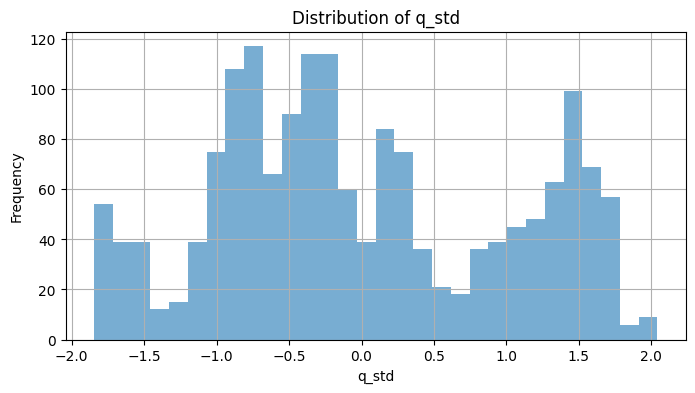

In [16]:
# 5) PSTR(1) ESTIMATION (UNIT FE), plus marginal effect plots
#---------------------------------------------------------------
def G_logistic(q_std, gamma, c):
    return 1.0 / (1.0 + np.exp(-gamma * (q_std - c)))


def pstr_objective_unitFE(params, df, qname="q_std"):
    gamma, c = params
    if gamma <= 1e-4:
        return 1e12
    qstd = df[qname].values
    x = df["x"].values
    y = df["y"].values
    u = df["unit"]

    G = G_logistic(qstd, gamma, c)
    y_dm = unit_demean(pd.Series(y), u)
    x_dm = unit_demean(pd.Series(x), u)
    xG_dm = unit_demean(pd.Series(x * G), u)

    X = np.column_stack([x_dm, xG_dm])  # [x, x*G]
    beta_hat = np.linalg.lstsq(X, y_dm, rcond=None)[0]
    resid = y_dm - X @ beta_hat
    return float(resid @ resid)


def estimate_pstr_unitFE(panel: pd.DataFrame, gamma_bounds=(0.5, 20.0)):
    df = panel.copy()

    # Grid init
    qs = df["q_std"].quantile([0.2, 0.4, 0.6, 0.8]).values
    gammas = [1.0, 5.0, 10.0, 15.0]
    init_grid = [(g, c0) for g in gammas for c0 in qs]

    best = None;
    best_val = np.inf
    for g0, c0 in init_grid:
        val = pstr_objective_unitFE((g0, c0), df)
        if val < best_val:
            best_val, best = val, (g0, c0)

    # Local refine
    bounds = ((gamma_bounds[0], gamma_bounds[1]), (-3.0, 3.0))  # c in z-units
    opt = minimize(lambda p: pstr_objective_unitFE(p, df),
                   x0=np.array(best), method="L-BFGS-B", bounds=bounds)
    gamma_hat, c_hat = opt.x

    # Final OLS (cluster by date)
    qstd = df["q_std"].values
    G = G_logistic(qstd, gamma_hat, c_hat)
    y_dm = unit_demean(df["y"], df["unit"])
    x_dm = unit_demean(df["x"], df["unit"])
    xG_dm = unit_demean(pd.Series(df["x"].values * G), df["unit"])

    X = np.column_stack([x_dm, xG_dm])
    ols = sm.OLS(y_dm, sm.add_constant(X)).fit(cov_type="cluster", cov_kwds={"groups": df["date"]})
    beta0, beta1 = ols.params[1], ols.params[2]
    se0, se1 = ols.bse[1], ols.bse[2]

    print("PSTR(1) unit-FE results (cluster-by-date):")
    print(ols.summary().tables[1])

    out = {
        "gamma": gamma_hat, "c": c_hat,
        "beta0": beta0, "beta1": beta1,
        "beta_low": beta0, "beta_high": beta0 + beta1,
        "se_beta0": se0, "se_beta1": se1,
        "ols": ols, "G": G,
        "y_dm": y_dm, "X": X
    }
    return out


pstr = estimate_pstr_unitFE(panel)

# Marginal effect and transition plots
q_grid = np.linspace(panel["q_std"].quantile(0.01), panel["q_std"].quantile(0.99), 250)
G_grid = G_logistic(q_grid, pstr["gamma"], pstr["c"])
me_grid = pstr["beta0"] + pstr["beta1"] * G_grid

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(q_grid, G_grid);
ax[0].set_title("Transition G(q_std)");
ax[0].set_xlabel("q_std");
ax[0].set_ylabel("G")
ax[1].plot(q_grid, me_grid);
ax[1].set_title("Marginal effect: dE[y]/dx");
ax[1].set_xlabel("q_std");
ax[1].set_ylabel("β0 + β1·G(q)")
plt.tight_layout();
plt.show()

panel["q_std"].plot(kind="hist", bins=30, alpha=0.6, title="Distribution of q_std");
plt.xlabel("q_std");
plt.show()

### 9) PSTR with Short-Rate Shocks and Lagged Effects

Swap the shock to Δ3M in bps (monetary-policy–proxy) and add lag $x_{t-1}$ to capture delayed equity responses predicted by macro-finance theory.

In [17]:
# swap x to Δ3M (bps) and add lagged x, then re-estimate
panel_x3m = panel.copy()
panel_x3m["x"] = rates["d_US_3M_bps"].reindex(panel_x3m["date"]).values
panel_x3m = panel_x3m.dropna()

# Add lagged x
panel_x3m["x_lag"] = panel_x3m.groupby("unit")["x"].shift(1)
panel_x3m = panel_x3m.dropna()


def estimate_pstr_unitFE_wlag(panel_df: pd.DataFrame, gamma_bounds=(0.5, 20.0)):
    df = panel_df.copy()
    qs = df["q_std"].quantile([0.2, 0.4, 0.6, 0.8]).values
    gammas = [1.0, 5.0, 10.0, 15.0]
    init_grid = [(g, c0) for g in gammas for c0 in qs]

    def obj(params):
        gamma, c = params
        if gamma <= 1e-4: return 1e12
        G = 1.0 / (1.0 + np.exp(-gamma * (df["q_std"].values - c)))
        y_dm = unit_demean(df["y"], df["unit"])
        x_dm = unit_demean(df["x"], df["unit"])
        xG_dm = unit_demean(pd.Series(df["x"].values * G), df["unit"])
        xl_dm = unit_demean(df["x_lag"], df["unit"])
        xlG_dm = unit_demean(pd.Series(df["x_lag"].values * G), df["unit"])
        X = np.column_stack([x_dm, xG_dm, xl_dm, xlG_dm])
        beta = np.linalg.lstsq(X, y_dm, rcond=None)[0]
        resid = y_dm - X @ beta
        return float(resid @ resid)

    # grid
    best, best_val = None, np.inf
    for g0, c0 in init_grid:
        v = obj((g0, c0))
        if v < best_val: best_val, best = v, (g0, c0)

    # local
    bounds = ((gamma_bounds[0], gamma_bounds[1]), (-3.0, 3.0))
    opt = minimize(lambda p: obj(p), x0=np.array(best), method="L-BFGS-B", bounds=bounds)
    gamma_hat, c_hat = opt.x

    # final OLS (cluster by date)
    G = 1.0 / (1.0 + np.exp(-gamma_hat * (df["q_std"].values - c_hat)))
    y_dm = unit_demean(df["y"], df["unit"])
    x_dm = unit_demean(df["x"], df["unit"])
    xG_dm = unit_demean(pd.Series(df["x"].values * G), df["unit"])
    xl_dm = unit_demean(df["x_lag"], df["unit"])
    xlG_dm = unit_demean(pd.Series(df["x_lag"].values * G), df["unit"])

    X = np.column_stack([x_dm, xG_dm, xl_dm, xlG_dm])
    ols = sm.OLS(y_dm, sm.add_constant(X)).fit(cov_type="cluster", cov_kwds={"groups": df["date"]})
    print("PSTR(1) with x and x_lag (cluster-by-date):")
    print(ols.summary().tables[1])
    return {"gamma": gamma_hat, "c": c_hat, "ols": ols}

# res_x3m_wlag = estimate_pstr_unitFE_wlag(panel_x3m)

In [18]:
#A) Panel shape and head
print("Weekly panel shape:", panel.shape)
print(panel.head())

# B) Summary stats for y (returns), x (rate shock, bps), q (state level)
desc = panel[["y","x","q"]].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
print("\nSummary stats (y, x in bps, q level):\n", desc)

# C) Linearity test (unit FE) — run if not already done
try:
    _ = lin_test["F"]
except:
    lin_test = linearity_test_unitFE_partial(panel)
print(f"\nLinearity test (unit FE): F={lin_test['F']:.3f}, p={lin_test['pval']:.4f}")

# D) PSTR(1) summary table + transition parameters
print("\nPSTR(1) unit-FE results (cluster-by-date):")
print(pstr["ols"].summary().tables[1])

# Threshold location in raw q units
c_hat = pstr["c"]; gamma_hat = pstr["gamma"]
q_mean, q_std = panel["q"].mean(), panel["q"].std(ddof=0)
c_raw = q_mean + c_hat*q_std
print(f"\nTransition params: gamma={gamma_hat:.3f}, c (std units)={c_hat:.3f}, threshold q (raw)={c_raw:.3f}")

Weekly panel shape: (1686, 6)
        date unit         y          x      q     q_std
0 2015-01-16   US -0.012495 -15.599990  1.815 -0.713583
1 2015-01-16   EU  0.051040 -15.599990  1.815 -0.713583
2 2015-01-16   JP -0.019587 -15.599990  1.815 -0.713583
3 2015-01-23   US  0.015917   0.199997  1.817 -0.711810
4 2015-01-23   EU  0.054779   0.199997  1.817 -0.711810

Summary stats (y, x in bps, q level):
     count      mean        std        min         1%         5%       25%  \
y  1686.0  0.001695   0.026095  -0.223003  -0.072874  -0.039609 -0.010658   
x  1686.0  0.348043  11.680021 -42.100000 -30.999994 -18.199992 -6.800008   
q  1686.0  2.619980   1.128417   0.536000   0.628000   0.749000  1.755000   

        50%       75%        95%        99%        max  
y  0.003201  0.015640   0.039711   0.062998   0.158171  
x -0.099999  7.300001  21.099997  30.699992  50.800014  
q  2.393000  3.695000   4.441000   4.629000   4.924000  

Linearity test (unit FE): F=21.754, p=0.0000

PSTR(1) un